In [1]:
import os
from os import listdir
import numpy as np
import pickle as pkl

from utils import Person

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from utils import analyze

In [395]:
# this is to find the zero timestepping of the davis
def find_trigger(ts):
    return np.where(np.diff(ts) < 0)[0][0] + 1

def create_frame(x, y, dim=(128, 128)):
    img = np.zeros(dim)
    for _x, _y in zip(x.astype('int32'), y.astype('int32')):
        img[dim[0] - 1 - _x,_y] += 1
    return img 

In [114]:
basedir = '/Users/enea/Downloads/'
subject = '03'
session = '03'
file_name = f"subject{subject}_session{session}_davis.npz"

In [6]:
davis_data = np.load(basedir + file_name)
print(list(davis_data.keys()))
davis_frames = davis_data['frames']
print(davis_frames.shape)
dvs_events = davis_data['dvs_events']
print(dvs_events.shape)

['frames_time', 'dvs_events', 'frames']
(2059, 180, 240)
(4, 12805566)


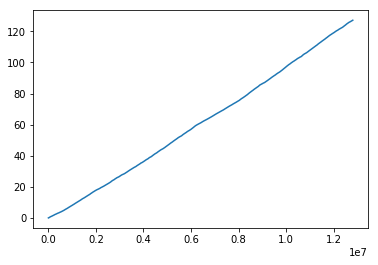

In [7]:
plt.plot(dvs_events[2])

In [10]:
# general stuff
fs = 200  # sampling frequency of MYO
VERBOSE = True
data_dir = '/Users/enea/Dropbox/Capocaccia2019_Gesture_DVS_Myo/Dataset/EMG/'
classes = classes = ['pinky', 'elle', 'yo', 'index', 'thumb']
classes_dict = {'pinky': 0, 'elle': 1, 'yo': 2, 'index': 3, 'thumb': 4}
classes_inv = {v: k for k, v in classes_dict.items()}

In [372]:
subjects = {}
names = sorted([name for name in listdir(data_dir) if "emg" in name])
for name in names:
    _emg = np.load(data_dir + '{}'.format(name)).astype('float32')
    _ann = np.concatenate([np.array(['none']), np.load(data_dir + '{}'.format(name.replace("emg","ann")))[:-1]])

    subjects["_".join(name.split("_")[:2])] = Person(name.split("_")[0], _emg, _ann, classes=classes)

    if VERBOSE:
        print("Loaded {}: EMG = [{}] // ANN = [{}]".format("_".join(name.split("_")[:2]), _emg.shape, len(_ann)))
print("Data Loaded! {} Sessions".format(len(subjects.keys())))

# separates data in correct trial type
for name, data in subjects.items():
    for _class in classes:
        _annotation = np.float32(data.ann == _class)
        derivative = np.diff(_annotation)/1.0
        begins = np.where(derivative == 1)[0]
        ends = np.where(derivative == -1)[0]
        for b, e in zip(begins, ends):
            _trials = data.emg[b:e]
            data.trials[_class].append(_trials)
            data.begs[_class].append(b)
            data.ends[_class].append(e)
print("Done sorting trials!")

Loaded subject01_session01: EMG = [(25290, 8)] // ANN = [25290]
Loaded subject01_session02: EMG = [(25089, 8)] // ANN = [25089]
Loaded subject01_session03: EMG = [(25244, 8)] // ANN = [25244]
Loaded subject02_session01: EMG = [(25077, 8)] // ANN = [25077]
Loaded subject02_session02: EMG = [(25331, 8)] // ANN = [25331]
Loaded subject02_session03: EMG = [(25318, 8)] // ANN = [25318]
Loaded subject03_session01: EMG = [(25315, 8)] // ANN = [25315]
Loaded subject03_session02: EMG = [(25306, 8)] // ANN = [25306]
Loaded subject03_session03: EMG = [(25328, 8)] // ANN = [25328]
Loaded subject04_session01: EMG = [(25315, 8)] // ANN = [25315]
Loaded subject04_session02: EMG = [(25328, 8)] // ANN = [25328]
Loaded subject04_session03: EMG = [(25242, 8)] // ANN = [25242]
Loaded subject05_session01: EMG = [(25358, 8)] // ANN = [25358]
Loaded subject05_session02: EMG = [(25330, 8)] // ANN = [25330]
Loaded subject05_session03: EMG = [(25332, 8)] // ANN = [25332]
Loaded subject06_session01: EMG = [(2499

In [373]:
# CORRECTION DICTIONARY for synchronization and allignment 
corrections = {}
corrections['subject01_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-15, 'cy':20}
corrections['subject01_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-10, 'cy':0}
corrections['subject01_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':10}
corrections['subject02_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-40, 'cy':5}
corrections['subject02_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-10, 'cy':5}

corrections['subject03_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}
corrections['subject03_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}
corrections['subject03_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}
corrections['subject04_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-30, 'cy':-15}
corrections['subject04_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-50, 'cy':-10}
corrections['subject04_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-40, 'cy':-10}
corrections['subject05_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-10, 'cy':-10}
corrections['subject05_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':10, 'cy':-10}
corrections['subject05_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-10, 'cy':-10}
corrections['subject06_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-10, 'cy':0}
corrections['subject06_session02'] = {'fs':197, 'tg':'base', 'shift':1.0, 'cx':5, 'cy':-5}
corrections['subject06_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':0}
corrections['subject07_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}
corrections['subject07_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':0}
corrections['subject07_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-10, 'cy':0}
corrections['subject08_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-20, 'cy':10}
corrections['subject08_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':0}
corrections['subject08_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':20, 'cy':0}
corrections['subject09_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}
corrections['subject09_session02'] = {'fs':185, 'tg':'base', 'shift':2.0, 'cx':-10, 'cy':-10}
corrections['subject09_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-10, 'cy':-20}
corrections['subject10_session01'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}
corrections['subject10_session02'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}
corrections['subject10_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':0, 'cy':-10}


corrections['subject11_session01'] = {'fs':174, 'tg':'single', 'shift':1.0, 'cx':-5, 'cy':10}
corrections['subject11_session02'] = {'fs':169, 'tg':'single', 'shift':0.5, 'cx':-5, 'cy':15}
corrections['subject11_session03'] = {'fs':173, 'tg':'single', 'shift':0.5, 'cx':-8, 'cy':10}
corrections['subject12_session01'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':10}
corrections['subject12_session02'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':10}
corrections['subject12_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':10}
corrections['subject13_session01'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':-10, 'cy':20}
corrections['subject13_session02'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':5, 'cy':15}
corrections['subject13_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':10}
corrections['subject14_session01'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':5}
corrections['subject14_session02'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':5}
corrections['subject14_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':8}
corrections['subject15_session01'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':-5, 'cy':15}
corrections['subject15_session02'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':15}
corrections['subject15_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':-5, 'cy':15}
corrections['subject16_session01'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':-10, 'cy':15}
corrections['subject16_session02'] = {'fs':200, 'tg':'single', 'shift':1.0, 'cx':-15, 'cy':15}
corrections['subject16_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':-20, 'cy':15}
corrections['subject17_session01'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':7, 'cy':10}
corrections['subject17_session02'] = {'fs':200, 'tg':'double', 'shift':0.5, 'cx':10, 'cy':10}
corrections['subject17_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':15, 'cy':15}
corrections['subject18_session01'] = {'fs':200, 'tg':'single', 'shift':1.0, 'cx':-3, 'cy':-5}
corrections['subject18_session02'] = {'fs':200, 'tg':'double', 'shift':0.5, 'cx':-10, 'cy':-15}
corrections['subject18_session03'] = {'fs':200, 'tg':'triple', 'shift':0.5, 'cx':-10, 'cy':-5}
corrections['subject19_session01'] = {'fs':167, 'tg':'single', 'shift':0.5, 'cx':0, 'cy':20}
corrections['subject19_session02'] = {'fs':173, 'tg':'single', 'shift':0.5, 'cx':-3, 'cy':15}
corrections['subject19_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':-3, 'cy':15}
corrections['subject20_session01'] = {'fs':174, 'tg':'single', 'shift':1.5, 'cx':-10, 'cy':10}
corrections['subject20_session02'] = {'fs':176, 'tg':'triple', 'shift':1.0, 'cx':-5, 'cy':0}
corrections['subject20_session03'] = {'fs':174, 'tg':'triple', 'shift':1.0, 'cx':-5, 'cy':5}

corrections['subject21_session01'] = {'fs':200, 'tg':'single', 'shift':1.0, 'cx':0, 'cy':0}
corrections['subject21_session02'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':2, 'cy':-2}
corrections['subject21_session03'] = {'fs':200, 'tg':'single', 'shift':0.5, 'cx':5, 'cy':5}


# weird no frames
corrections['subject02_session03'] = {'fs':200, 'tg':'base', 'shift':1.0, 'cx':-3, 'cy':0}

print(len(list(corrections.keys())))

63


In [346]:
subject = '06'
session = '02'
file_name = f"subject{subject}_session{session}_davis.npz"
davis_data = np.load(basedir + file_name)
print(list(davis_data.keys()))

['frames_time', 'dvs_events', 'frames']


(1907, 180, 240)
(4, 15364823)
98.09644670050761
100.08629441624366
(4, 27520)
(120, 120)
(40, 40)


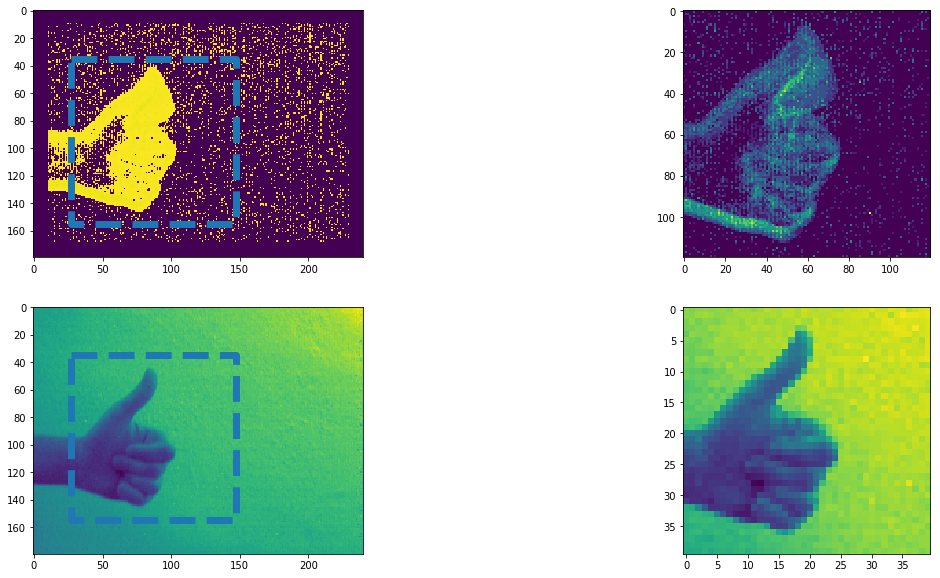

In [348]:
gesture = 'thumb'
trial = 3
davis_frames = davis_data['frames']
davis_times = davis_data['frames_time']
print(davis_frames.shape)
dvs_events = davis_data['dvs_events']
print(dvs_events.shape)
fs = 197
# load beginning and end 
b = np.array(subjects[f"subject{subject}_session{session}"].begs[gesture][trial]) / fs
e = np.array(subjects[f"subject{subject}_session{session}"].ends[gesture][trial]) / fs

print(b)
print(e)

frame_size = 0.2
shift = 2.5
beginning = b + shift
ending = beginning + frame_size
# slice
sl = (dvs_events[2] > beginning) & (dvs_events[2] < ending)

sl2 = (davis_times > beginning) & (davis_times < ending)

times = davis_times[sl2]
imgs = davis_frames[sl2]

img = dvs_events[:, sl]
print(img.shape)
fig, ax = plt.subplots(2, 2, figsize=(20,10))

beg_int = int(shift * fs)
end_int = int((shift + frame_size) * fs)

sll = (img[1] > 10) & (img[1] < 170) & (img[0] > 10) & (img[0] < 230)

kkk = create_frame(img[1][sll], img[0][sll], dim=(180, 240))

frame = np.uint8(kkk * 255)

M = cv2.moments(frame)
x = int(M["m10"] / M["m00"])
y = int(M["m01"] / M["m00"])

S = 120 // 2
corr_x = 5
corr_y = -5

a = (img[0] > (x - S - corr_x)) & (img[0] < (x + S - corr_x))
b = (img[1] > (180 - y - S + corr_y)) & (img[1] < (180 - y + S + corr_y))

xxx = img[1][a & b]
yyy = img[0][a & b]

kkk = create_frame(xxx - min(xxx), yyy - min(yyy) , dim=(S * 2, S * 2))

_ = ax[0][0].imshow(frame)
ax[0][0].plot([x - S - corr_x, x + S - corr_x, x + S - corr_x, x - S - corr_x, x - S - corr_x], 
           [y  - S - corr_y, y  - S - corr_y, y + S - corr_y, y  + S - corr_y, y  - S - corr_y], '--', linewidth=7)

_ = ax[0][1].imshow(kkk)

iii = imgs[0][::-1, :][:, ::-1]

_ = ax[1][0].imshow(iii)
ax[1][0].plot([x - S - corr_x, x + S - corr_x, x + S - corr_x, x - S - corr_x, x - S - corr_x], 
           [y  - S - corr_y, y  - S - corr_y, y + S - corr_y, y  + S - corr_y, y  - S - corr_y], '--', linewidth=7)

aa = iii[max(0, y - S - corr_y): y + S - corr_y, x - S - corr_x:x + S - corr_x]

if (aa.shape[0] < S * 2):
    aa = np.concatenate([np.zeros((S * 2 - aa.shape[0], aa.shape[1])), aa])

print(aa.shape)

aa = cv2.resize(aa, None, fx=0.33, fy=0.33, interpolation=cv2.INTER_CUBIC)

print(aa.shape)

_ = ax[1][1].imshow(aa)

In [351]:
# saving tiff for manual labelling
for subject, data in subjects.items():
    davis_frames = davis_data['frames']
    davis_times = davis_data['frames_time']
    dvs_events = davis_data['dvs_events']
    corr = corrections[subject]
    if subject != 'subject02_session03':
        for gesture in classes:
            for trial in range(5):
                print("{} :: {} :: {}".format(subject, gesture, trial))

                # load beginning and end 
                b = np.array(subjects[subject].begs[gesture][trial]) / corr['fs']
                e = np.array(subjects[subject].ends[gesture][trial]) / corr['fs']

                frame_size = 2.0
                shift = corr['shift']
                beginning = b + shift
                ending = beginning + frame_size
                # slice
                sl = (dvs_events[2] > beginning) & (dvs_events[2] < ending)
                sl2 = (davis_times > beginning) & (davis_times < ending)

                times = davis_times[sl2]
                imgs = davis_frames[sl2][4:-4]
                
                for kk, iii in enumerate(imgs):
                    plt.imsave(f'./dump/img_src/{subject}_{gesture}_{trial}_{kk}.tiff', iii)
                    

subject01_session01 :: pinky :: 0
subject01_session01 :: pinky :: 1
subject01_session01 :: pinky :: 2
subject01_session01 :: pinky :: 3
subject01_session01 :: pinky :: 4
subject01_session01 :: elle :: 0
subject01_session01 :: elle :: 1
subject01_session01 :: elle :: 2
subject01_session01 :: elle :: 3
subject01_session01 :: elle :: 4
subject01_session01 :: yo :: 0
subject01_session01 :: yo :: 1
subject01_session01 :: yo :: 2
subject01_session01 :: yo :: 3
subject01_session01 :: yo :: 4
subject01_session01 :: index :: 0
subject01_session01 :: index :: 1
subject01_session01 :: index :: 2
subject01_session01 :: index :: 3
subject01_session01 :: index :: 4
subject01_session01 :: thumb :: 0
subject01_session01 :: thumb :: 1
subject01_session01 :: thumb :: 2
subject01_session01 :: thumb :: 3
subject01_session01 :: thumb :: 4
subject01_session02 :: pinky :: 0
subject01_session02 :: pinky :: 1
subject01_session02 :: pinky :: 2
subject01_session02 :: pinky :: 3
subject01_session02 :: pinky :: 4


subject04_session02 :: thumb :: 2
subject04_session02 :: thumb :: 3
subject04_session02 :: thumb :: 4
subject04_session03 :: pinky :: 0
subject04_session03 :: pinky :: 1
subject04_session03 :: pinky :: 2
subject04_session03 :: pinky :: 3
subject04_session03 :: pinky :: 4
subject04_session03 :: elle :: 0
subject04_session03 :: elle :: 1
subject04_session03 :: elle :: 2
subject04_session03 :: elle :: 3
subject04_session03 :: elle :: 4
subject04_session03 :: yo :: 0
subject04_session03 :: yo :: 1
subject04_session03 :: yo :: 2
subject04_session03 :: yo :: 3
subject04_session03 :: yo :: 4
subject04_session03 :: index :: 0
subject04_session03 :: index :: 1
subject04_session03 :: index :: 2
subject04_session03 :: index :: 3
subject04_session03 :: index :: 4
subject04_session03 :: thumb :: 0
subject04_session03 :: thumb :: 1
subject04_session03 :: thumb :: 2
subject04_session03 :: thumb :: 3
subject04_session03 :: thumb :: 4
subject05_session01 :: pinky :: 0
subject05_session01 :: pinky :: 1


subject07_session03 :: index :: 4
subject07_session03 :: thumb :: 0
subject07_session03 :: thumb :: 1
subject07_session03 :: thumb :: 2
subject07_session03 :: thumb :: 3
subject07_session03 :: thumb :: 4
subject08_session01 :: pinky :: 0
subject08_session01 :: pinky :: 1
subject08_session01 :: pinky :: 2
subject08_session01 :: pinky :: 3
subject08_session01 :: pinky :: 4
subject08_session01 :: elle :: 0
subject08_session01 :: elle :: 1
subject08_session01 :: elle :: 2
subject08_session01 :: elle :: 3
subject08_session01 :: elle :: 4
subject08_session01 :: yo :: 0
subject08_session01 :: yo :: 1
subject08_session01 :: yo :: 2
subject08_session01 :: yo :: 3
subject08_session01 :: yo :: 4
subject08_session01 :: index :: 0
subject08_session01 :: index :: 1
subject08_session01 :: index :: 2
subject08_session01 :: index :: 3
subject08_session01 :: index :: 4
subject08_session01 :: thumb :: 0
subject08_session01 :: thumb :: 1
subject08_session01 :: thumb :: 2
subject08_session01 :: thumb :: 3


In [328]:
for subject, data in subjects.items():
    davis_frames = davis_data['frames']
    davis_times = davis_data['frames_time']
    dvs_events = davis_data['dvs_events']
    corr = corrections[subject]
    if subject != 'subject02_session03':
        for gesture in classes:
            for trial in range(5):
                print("{} :: {} :: {}".format(subject, gesture, trial))

                # load beginning and end 
                b = np.array(subjects[subject].begs[gesture][trial]) / corr['fs']
                e = np.array(subjects[subject].ends[gesture][trial]) / corr['fs']

                frame_size = 2.0
                shift = corr['shift']
                beginning = b + shift
                ending = beginning + frame_size
                # slice
                sl = (dvs_events[2] > beginning) & (dvs_events[2] < ending)
                sl2 = (davis_times > beginning) & (davis_times < ending)

                times = davis_times[sl2]
                imgs = davis_frames[sl2]

                img = dvs_events[:, sl]

                beg_int = int(shift * fs)
                end_int = int((shift + frame_size) * fs)

                sll = (img[1] > 10) & (img[1] < 170) & (img[0] > 10) & (img[0] < 230)
                kkk = create_frame(img[1][sll], img[0][sll], dim=(180, 240))
                frame = np.uint8(kkk * 255)

                M = cv2.moments(frame)
                x = int(M["m10"] / M["m00"])
                y = int(M["m01"] / M["m00"])

                S = 120 // 2
                corr_x = corr['cx']
                corr_y = corr['cy']

                iii = imgs[:][::-1, :][:, ::-1]

                new_imgs = []
                for ii in iii:
                    aa = ii[max(0, y - S - corr_y): y + S - corr_y, x - S - corr_x:x + S - corr_x]

                    if (aa.shape[0] < S * 2):
                        aa = np.concatenate([np.zeros((S * 2 - aa.shape[0], aa.shape[1])), aa])

                    # subsample
                    aa = cv2.resize(aa, None, fx=0.33, fy=0.33, interpolation=cv2.INTER_CUBIC)
                    new_imgs.append(aa)

                data.frames[gesture].append(new_imgs)
                data.ts_frames[gesture].append(aa)

subject01_session01 :: pinky :: 0
subject01_session01 :: pinky :: 1
subject01_session01 :: pinky :: 2
subject01_session01 :: pinky :: 3
subject01_session01 :: pinky :: 4
subject01_session01 :: elle :: 0
subject01_session01 :: elle :: 1
subject01_session01 :: elle :: 2
subject01_session01 :: elle :: 3
subject01_session01 :: elle :: 4
subject01_session01 :: yo :: 0
subject01_session01 :: yo :: 1
subject01_session01 :: yo :: 2
subject01_session01 :: yo :: 3
subject01_session01 :: yo :: 4
subject01_session01 :: index :: 0
subject01_session01 :: index :: 1
subject01_session01 :: index :: 2
subject01_session01 :: index :: 3
subject01_session01 :: index :: 4
subject01_session01 :: thumb :: 0
subject01_session01 :: thumb :: 1
subject01_session01 :: thumb :: 2
subject01_session01 :: thumb :: 3
subject01_session01 :: thumb :: 4
subject01_session02 :: pinky :: 0
subject01_session02 :: pinky :: 1
subject01_session02 :: pinky :: 2
subject01_session02 :: pinky :: 3
subject01_session02 :: pinky :: 4


subject04_session02 :: thumb :: 2
subject04_session02 :: thumb :: 3
subject04_session02 :: thumb :: 4
subject04_session03 :: pinky :: 0
subject04_session03 :: pinky :: 1
subject04_session03 :: pinky :: 2
subject04_session03 :: pinky :: 3
subject04_session03 :: pinky :: 4
subject04_session03 :: elle :: 0
subject04_session03 :: elle :: 1
subject04_session03 :: elle :: 2
subject04_session03 :: elle :: 3
subject04_session03 :: elle :: 4
subject04_session03 :: yo :: 0
subject04_session03 :: yo :: 1
subject04_session03 :: yo :: 2
subject04_session03 :: yo :: 3
subject04_session03 :: yo :: 4
subject04_session03 :: index :: 0
subject04_session03 :: index :: 1
subject04_session03 :: index :: 2
subject04_session03 :: index :: 3
subject04_session03 :: index :: 4
subject04_session03 :: thumb :: 0
subject04_session03 :: thumb :: 1
subject04_session03 :: thumb :: 2
subject04_session03 :: thumb :: 3
subject04_session03 :: thumb :: 4
subject05_session01 :: pinky :: 0
subject05_session01 :: pinky :: 1


subject07_session03 :: index :: 4
subject07_session03 :: thumb :: 0
subject07_session03 :: thumb :: 1
subject07_session03 :: thumb :: 2
subject07_session03 :: thumb :: 3
subject07_session03 :: thumb :: 4
subject08_session01 :: pinky :: 0
subject08_session01 :: pinky :: 1
subject08_session01 :: pinky :: 2
subject08_session01 :: pinky :: 3
subject08_session01 :: pinky :: 4
subject08_session01 :: elle :: 0
subject08_session01 :: elle :: 1
subject08_session01 :: elle :: 2
subject08_session01 :: elle :: 3
subject08_session01 :: elle :: 4
subject08_session01 :: yo :: 0
subject08_session01 :: yo :: 1
subject08_session01 :: yo :: 2
subject08_session01 :: yo :: 3
subject08_session01 :: yo :: 4
subject08_session01 :: index :: 0
subject08_session01 :: index :: 1
subject08_session01 :: index :: 2
subject08_session01 :: index :: 3
subject08_session01 :: index :: 4
subject08_session01 :: thumb :: 0
subject08_session01 :: thumb :: 1
subject08_session01 :: thumb :: 2
subject08_session01 :: thumb :: 3


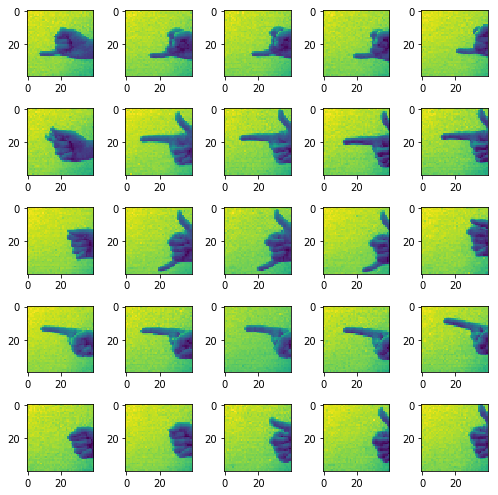

In [343]:
# plot full session
data = subjects['subject03_session01']

fig, ax = plt.subplots(5, 5, figsize=(7, 7))

for i in range(5):
    for j in range(5):
        gesture = classes[i]
        trial = j
        ax[i][j].imshow(data.frames[gesture][trial][2])
plt.tight_layout()

In [402]:
# just debug
subject = 'subject13_session02'
dvs_dir = '/Users/enea/Downloads/'
davis_data = np.load(dvs_dir + subject + "_davis.npz")

davis_frames = davis_data['frames']
davis_times = davis_data['frames_time']
print(davis_frames.shape)
dvs_events = davis_data['dvs_events']
print(dvs_events.shape)

(2794, 180, 240)
(4, 2506190)


[44]


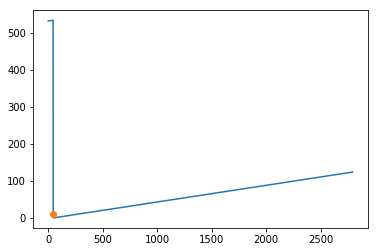

In [403]:
plt.plot(davis_times)
a = np.where(np.diff(davis_times) < 0)[0]
plt.plot(a, np.ones(len(a)) * 10, 'o')
print(a)

In [368]:
# SINGLE FIX
a = np.where(np.diff(davis_times) < 0)[0]
print(a)
davis_times = davis_times[a[0] + 1:]
davis_frames = davis_frames[a[0] + 1:]
c = np.where(np.diff(davis_times) < 0)[0]
print(c)
davis_times = davis_times[a[0] + 1:]
davis_frames = davis_frames[a[0] + 1:]
davis_times[c[0] + 1:] += davis_times[c[0]]
# evs[2] /= 1e3

[42 43]
[0]


In [ ]:
# DOUBLE FIX
a = np.where(np.diff(davis_times) < 0)[0]
print(a)
davis_times = davis_times[a[0] + 1:]
davis_frames = davis_frames[a[0] + 1:]
c = np.where(np.diff(davis_times) < 0)[0]
print(c)
davis_times = davis_times[a[0] + 1:]
davis_frames = davis_frames[a[0] + 1:]
davis_times[2, c[1] + 1:] += davis_times[c[1]]

In [ ]:
# TRIPLE FIX
a = np.where(np.diff(davis_times) < 0)[0]
print(a)
davis_times = davis_times[a[1] + 1:]
davis_frames = davis_frames[a[1] + 1:]
c = np.where(np.diff(davis_times) < 0)[0]
print(c)
davis_times = davis_times[a[1] + 1:]
davis_frames = davis_frames[a[1] + 1:]
davis_times[2, c[0] + 1:] += davis_times[c[0]]

In [404]:
# base
k = find_trigger(davis_times)
davis_times = davis_times[k:]
davis_frames = davis_frames[k:]

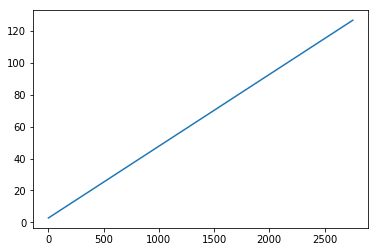

In [405]:
plt.plot(evs)

122.89
124.89
(40, 40)
(40, 40)


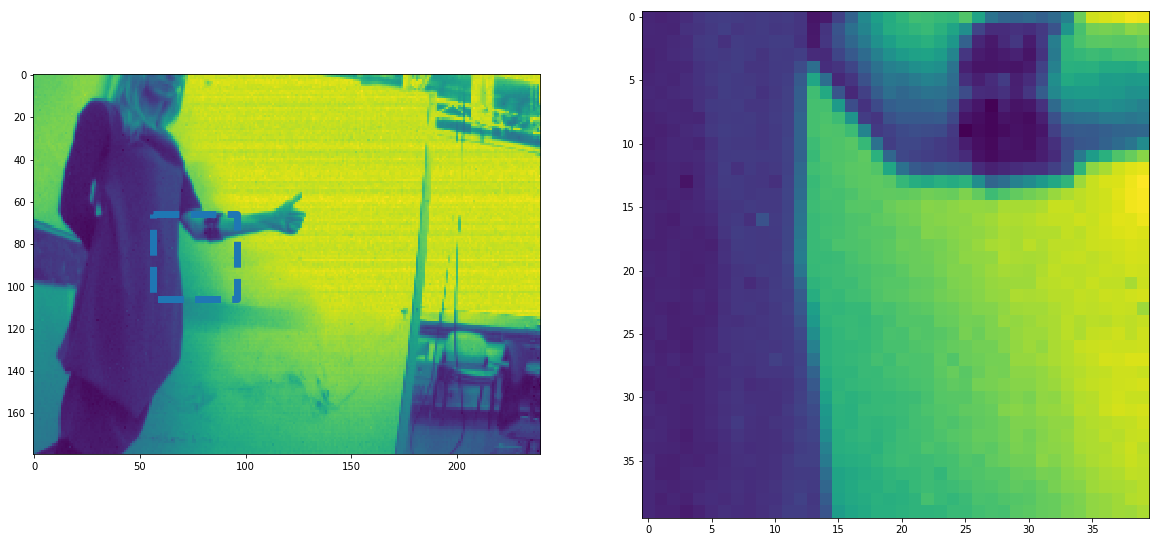

In [414]:
gesture = 'thumb'
trial = 4

# load beginning and end 
b = np.array(subjects[subject].begs[gesture][trial]) / corrections[subject]['fs']
e = np.array(subjects[subject].ends[gesture][trial]) / corrections[subject]['fs']

print(b)
print(e)

frame_size = 0.2
shift = -3
beginning = b + shift
ending = beginning + frame_size
# slice

sl2 = (davis_times > beginning) & (davis_times < ending)

times = davis_times[sl2]
imgs = davis_frames[sl2]


fig, ax = plt.subplots(1, 2, figsize=(20,10))


iii = imgs[0][::-1, :][:, ::-1]

_ = ax[0].imshow(iii)
ax[0].plot([x - S - corr_x, x + S - corr_x, x + S - corr_x, x - S - corr_x, x - S - corr_x], 
           [y  - S - corr_y, y  - S - corr_y, y + S - corr_y, y  + S - corr_y, y  - S - corr_y], '--', linewidth=7)

aa = iii[max(0, y - S - corr_y): y + S - corr_y, x - S - corr_x:x + S - corr_x]

# if (aa.shape[0] < S * 2):
#     aa = np.concatenate([np.zeros((S * 2 - aa.shape[0], aa.shape[1])), aa])
    
# if (aa.shape[1] < S * 2):
#     aa = np.concatenate([np.zeros((aa.shape[0], S * 2 - aa.shape[1])), aa], 1)

print(aa.shape)

# aa = cv2.resize(aa, None, fx=0.25, fy=0.25, interpolation=cv2.INTER_CUBIC)

print(aa.shape)

_ = ax[1].imshow(aa)